# <center>Stock Market Prediction</center>


In [1]:
# conda install -c conda-forge fbprophet

In [184]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, pytz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
from subprocess import check_output

from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from fbprophet import Prophet
plt.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'fbprophet'

### Abstract

This project investigates the applicability of machine learning methods to forecasting price movements in Stock Market. Stock Market predictions have historically been a problem tackled by different singular approaches even though markets are influenced by many different factors. The proposed model leverages XGBoost to predict a stock price, long short-term memory (LSTM) and ARIMA approach to predict a multiplier. Sentiment analysis is then used to capture the impact of various factors on stock prices, including market trends, economic indicators, and public opinion. The results of the model are compared to traditional prediction models using historical stock data, and it is shown that the proposed model provides improved accuracy in predicting future stock prices. The proposed model represents a significant step forward in stock price prediction, providing a more comprehensive and effective approach to predicting stock prices based on multiple factors.

In [4]:
# dji_df = yf.download('DJI', start='2022-01-01', interval='1h')

In [103]:
stock_symbol = '^DJI'

# Set the time period
start_date = '2022-01-01'
end_date = '2023-10-31'
split_date = '01-Jul-2023'

# Get the data for the stock
stock_data = yf.Ticker(stockSymbol)

# Fetch the historical prices for the chosen time period
stock_df = stockData.history(start=start_date, end=end_date, interval="1h")

stock_df.reset_index(inplace=True)

# Add a new column that replaces the index column
stock_df['Weighted_Price'] = (stock_df['Open'] + stock_df['Low'] + stock_df['High'] + 2 * stock_df['Close']) / 5

In [87]:
stock_df.index

RangeIndex(start=0, stop=3205, step=1)

In [88]:
stock_df.head() 

Datetime          Open          High           Low  \
0 2022-01-03 09:30:00-05:00  36321.589844  36502.511719  36246.449219   
1 2022-01-03 10:30:00-05:00  36464.800781  36468.328125  36324.199219   
2 2022-01-03 11:30:00-05:00  36367.878906  36420.039062  36280.351562   
3 2022-01-03 12:30:00-05:00  36417.339844  36441.121094  36367.410156   
4 2022-01-03 13:30:00-05:00  36441.050781  36524.000000  36419.539062   

          Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  36462.058594         0        0.0           0.0    36398.933594  
1  36368.128906  42963180        0.0           0.0    36398.717187  
2  36417.359375  30389408        0.0           0.0    36380.597656  
3  36441.121094  26296165        0.0           0.0    36421.622656  
4  36504.601562  30818008        0.0           0.0    36478.758594

In [89]:
stock_df.shape

(3205, 9)

In [90]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3205 entries, 0 to 3204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype                           
---  ------          --------------  -----                           
 0   Datetime        3205 non-null   datetime64[ns, America/New_York]
 1   Open            3205 non-null   float64                         
 2   High            3205 non-null   float64                         
 3   Low             3205 non-null   float64                         
 4   Close           3205 non-null   float64                         
 5   Volume          3205 non-null   int64                           
 6   Dividends       3205 non-null   float64                         
 7   Stock Splits    3205 non-null   float64                         
 8   Weighted_Price  3205 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(7), int64(1)
memory usage: 225.5 KB


In [91]:
#First replace N/A value if exist with zero

stock_df['Volume'].fillna(value=0, inplace=True)
stock_df['Dividends'].fillna(value=0, inplace=True)
stock_df['Stock Splits'].fillna(value=0, inplace=True)


# next need to fix the (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
stock_df['Open'].fillna(method='ffill', inplace=True)
stock_df['High'].fillna(method='ffill', inplace=True)
stock_df['Low'].fillna(method='ffill', inplace=True)
stock_df['Close'].fillna(method='ffill', inplace=True)

stock_df.head()

Datetime          Open          High           Low  \
0 2022-01-03 09:30:00-05:00  36321.589844  36502.511719  36246.449219   
1 2022-01-03 10:30:00-05:00  36464.800781  36468.328125  36324.199219   
2 2022-01-03 11:30:00-05:00  36367.878906  36420.039062  36280.351562   
3 2022-01-03 12:30:00-05:00  36417.339844  36441.121094  36367.410156   
4 2022-01-03 13:30:00-05:00  36441.050781  36524.000000  36419.539062   

          Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  36462.058594         0        0.0           0.0    36398.933594  
1  36368.128906  42963180        0.0           0.0    36398.717187  
2  36417.359375  30389408        0.0           0.0    36380.597656  
3  36441.121094  26296165        0.0           0.0    36421.622656  
4  36504.601562  30818008        0.0           0.0    36478.758594

Creating Weekly Rows for the better Data Visualization

In [94]:
# create valid date range
start = datetime.datetime(2022, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2023, 10, 31, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = stock_df[(stock_df['Datetime'] >= start) & (stock_df['Datetime'] <= end)].groupby([pd.Grouper(key='Datetime', freq='W-MON')]).first().reset_index()
weekly_rows.head()

Datetime          Open          High           Low  \
0 2022-01-03 00:00:00-05:00  36321.589844  36502.511719  36246.449219   
1 2022-01-10 00:00:00-05:00  36636.000000  36907.058594  36636.000000   
2 2022-01-17 00:00:00-05:00  36058.851562  36093.390625  35769.378906   
3 2022-01-24 00:00:00-05:00  35661.761719  35661.761719  35324.550781   
4 2022-01-31 00:00:00-05:00  34186.640625  34186.640625  33545.519531   

          Close  Volume  Dividends  Stock Splits  Weighted_Price  
0  36462.058594       0        0.0           0.0    36398.933594  
1  36906.738281       0        0.0           0.0    36798.507031  
2  35882.019531       0        0.0           0.0    35937.132031  
3  35407.640625       0        0.0           0.0    35492.671094  
4  33980.070312       0        0.0           0.0    33975.788281

In [96]:
# xXXXXXXX
trace1 = go.Scatter(
    x = weekly_rows['Datetime'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Datetime'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Datetime'],
    y = weekly_rows['High'].astype(float),
    mode = 'lines',
    name = 'High'
)

layout = dict(
    title='Historical Dow Jones Prices (2022-2023)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")



# figure = go.Figure(data = [go.Candlestick(x = stockDf['Datetime'],
#                                         open = stockDf["Open"], 
#                                         high = stockDf["High"],
#                                         low = stockDf["Low"], 
#                                         close = stockDf["Close"])])
# figure.update_layout(title = "Time Series Analysis (Candlestick Chart with Buttons and Slider)")

# figure.update_xaxes(
#     rangeslider_visible = True,
#     rangeselector = dict(
#         buttons = list([
#             dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
#             dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
#             dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
#             dict(step = "all")
#         ])
#     )
# )
# figure.show()

In [97]:
#Plot Historical DJ30 Volume

trace1 = go.Scatter(
    x = stockDf['Datetime'],
    y = stockDf['Volume'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Dow Jones Volume (USD) (2022-2023) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig)

#### Time Series Forecasting

Predicting using LSTM

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [100]:
data = stock_df[['Datetime','Weighted_Price']]

In [101]:
data.head()

Datetime  Weighted_Price
0 2022-01-03 09:30:00-05:00    36398.933594
1 2022-01-03 10:30:00-05:00    36398.717187
2 2022-01-03 11:30:00-05:00    36380.597656
3 2022-01-03 12:30:00-05:00    36421.622656
4 2022-01-03 13:30:00-05:00    36478.758594

In [102]:
data.shape

(3205, 2)

In [110]:
# split data
data_train = data.loc[data['Datetime'] <= split_date].copy()
data_test = data.loc[data['Datetime'] > split_date].copy()


In [111]:
data_train.set_index('Datetime', inplace=True)

In [112]:
data_test.set_index('Datetime', inplace=True)

In [113]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Datetime'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price Over Time', xaxis_title='Datetime', yaxis_title='Weighted Price USD')
fig.show()

In [115]:
# Plot the data using go.Scatter with different colors
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Weighted_Price'], mode='lines' ,name='Train set', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Weighted_Price'], mode='lines', name='Test set', line=dict(color='blue')))
fig.update_layout(title='Dow Jones Weighted price ', xaxis_title='Time', yaxis_title='USD $')
fig.add_vline(x='2023-07-01', line_dash="dash", line_color="red") #To be adjust
fig.show()


In [117]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
53/53 - 2s - loss: 0.1657 - 2s/epoch - 36ms/step
Epoch 2/100
53/53 - 0s - loss: 0.0650 - 219ms/epoch - 4ms/step
Epoch 3/100
53/53 - 0s - loss: 0.0621 - 207ms/epoch - 4ms/step
Epoch 4/100
53/53 - 0s - loss: 0.0588 - 196ms/epoch - 4ms/step
Epoch 5/100
53/53 - 0s - loss: 0.0548 - 198ms/epoch - 4ms/step
Epoch 6/100
53/53 - 0s - loss: 0.0503 - 200ms/epoch - 4ms/step
Epoch 7/100
53/53 - 0s - loss: 0.0498 - 194ms/epoch - 4ms/step
Epoch 8/100
53/53 - 0s - loss: 0.0471 - 198ms/epoch - 4ms/step
Epoch 9/100
53/53 - 0s - loss: 0.0433 - 219ms/epoch - 4ms/step
Epoch 10/100
53/53 - 0s - loss: 0.0413 - 204ms/epoch - 4ms/step
Epoch 11/100
53/53 - 0s - loss: 0.0387 - 201ms/epoch - 4ms/step
Epoch 12/100
53/53 - 0s - loss: 0.0360 - 199ms/epoch - 4ms/step
Epoch 13/100
53/53 - 0s - loss: 0.0347 - 189ms/epoch - 4ms/step
Epoch 14/100
53/53 - 0s - loss: 0.0313 - 186ms/epoch - 4ms/step
Epoch 15/100
53/53 - 0s - loss: 0.0294 - 188ms/epoch - 4ms/step
Epoch 16/100
53/53 - 0s - loss: 0.0272 - 195ms/epoc

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_stock_price = model.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

19/19 [==============================] - 0s 2ms/step


In [120]:
data_test['Weighted_Price_Prediction'] = predicted_stock_price
data_all = pd.concat([data_test, data_train], sort=False)

In [121]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Datetime','Weighted_Price','lstm']]

<Axes: xlabel='Datetime'>

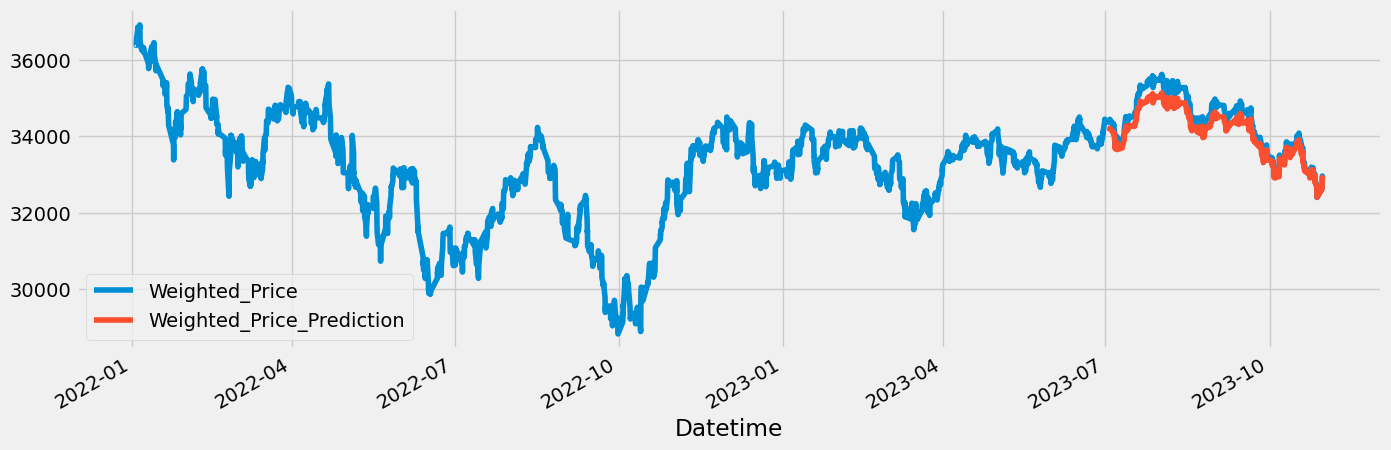

In [125]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))


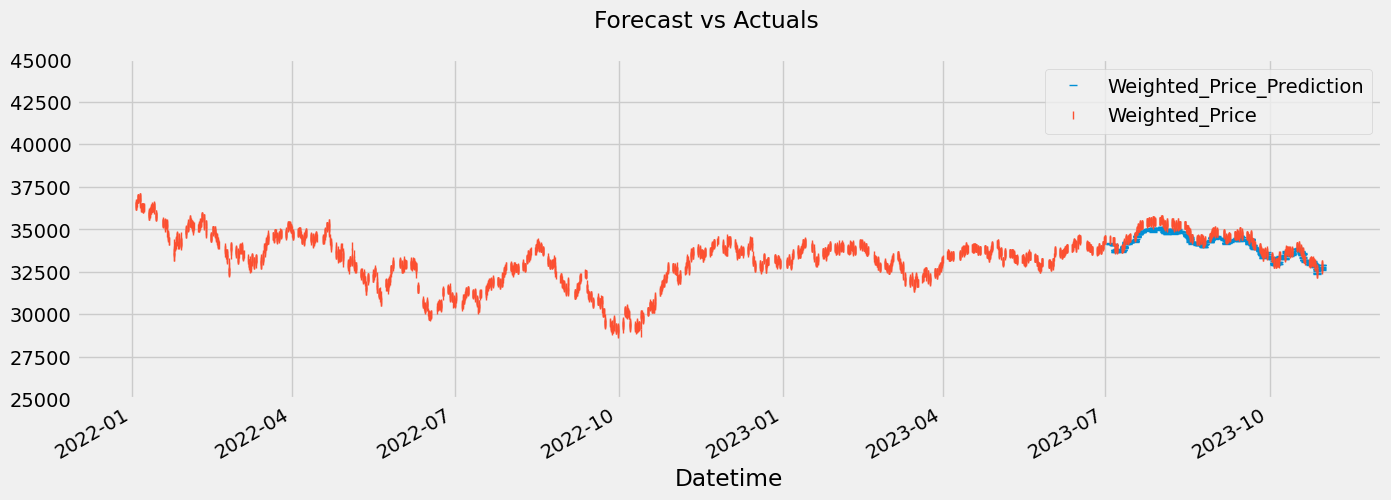

In [126]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['_','|'])
ax.set_ylim(25000, 45000)
plot = plt.suptitle('Forecast vs Actuals')

In [127]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

72457.90766031812

In [128]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

236.5500066887842

Time Series forecasting with XGBoost

In [33]:
data = stock_df[['Datetime','Weighted_Price']]

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Datetime'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price', xaxis_title='Datetime', yaxis_title='Weighted Price USD')
fig.show()

In [129]:
data_train = data.loc[data['Datetime'] <= split_date].copy()
data_test = data.loc[data['Datetime'] > split_date].copy()
data_train.set_index('Datetime', inplace=True)
data_test.set_index('Datetime', inplace=True)

In [130]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Weighted_Price'], mode='lines' ,name='Train set', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Weighted_Price'], mode='lines', name='Test set', line=dict(color='blue')))
fig.update_layout(title='Dow Jones Weighted price ', xaxis_title='Time', yaxis_title='USD $')
fig.show()


In [131]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth',]]
    if label:
        y = df[label]
        return X, y
    return X

In [132]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

Here we use a basic XGBRegressor model,

In [134]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train




# model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 100)
# model.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
# #         early_stopping_rounds=50,
#        verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [135]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Datetime','Weighted_Price','lstm','xgboost']]

ValueError: in user code:

    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\zhely\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 1, 1), found shape=(None, 7)


Feature Importances

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and day of week came in next. Quarter has low importance due to the fact that it could be created by different day of year splits.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

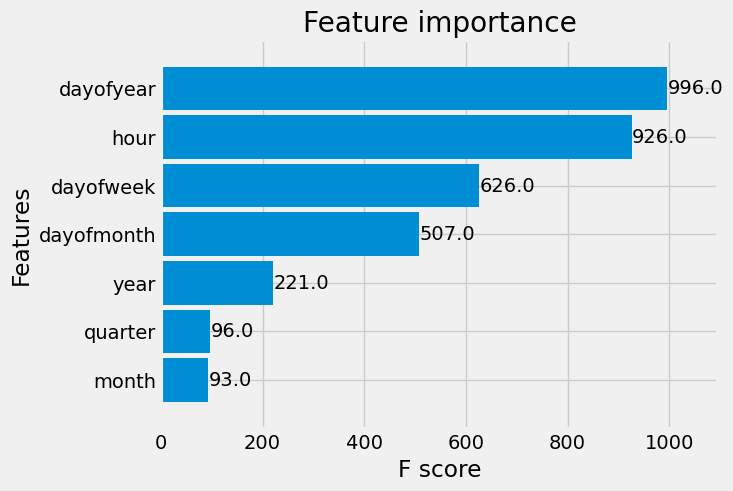

In [138]:
plot_importance(reg, height=0.9)

Forecast on Test Set

In [148]:
data_test['Weighted_Price_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

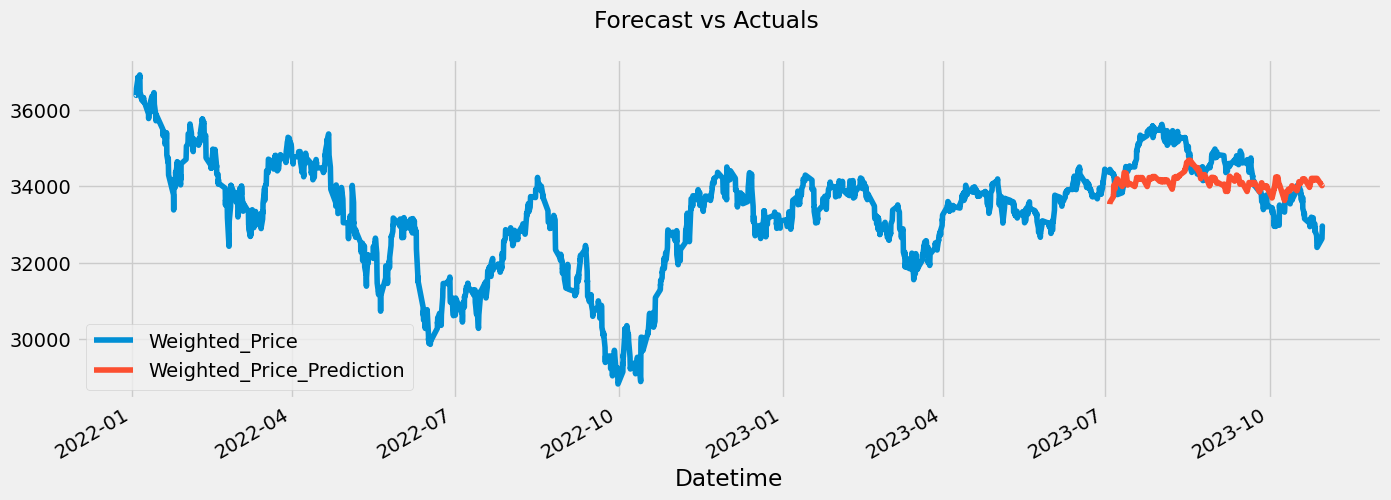

In [151]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))
plot = plt.suptitle('Forecast vs Actuals')

Look at first month of predictions


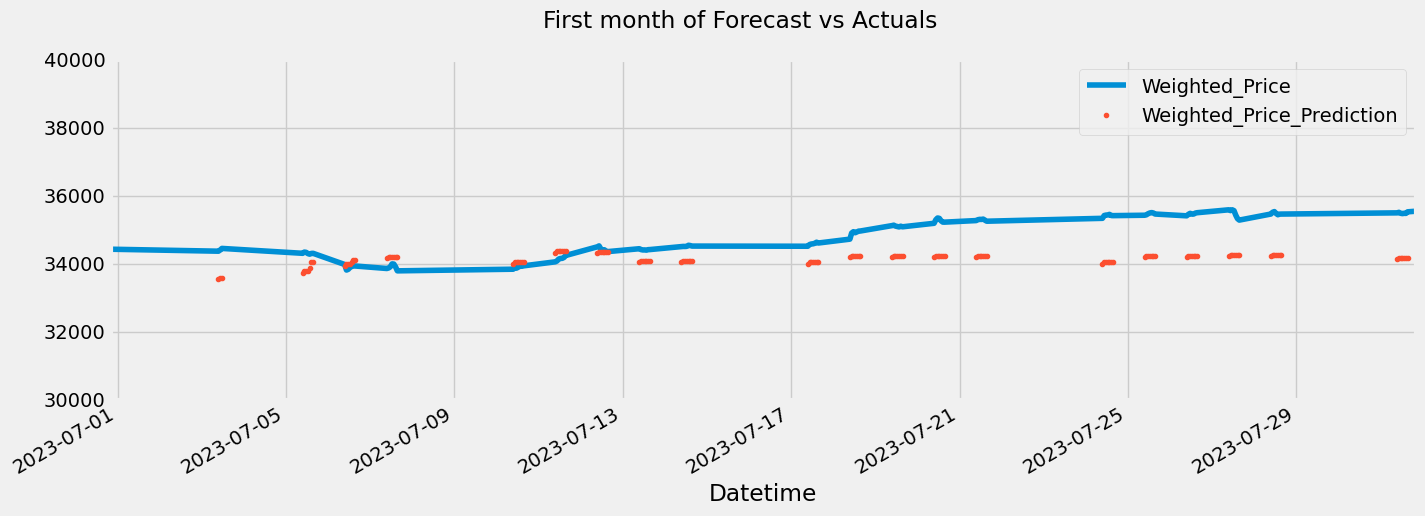

In [158]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2023-07-01', upper='2023-08-01')
ax.set_ylim(30000, 40000)
plot = plt.suptitle('First month of Forecast vs Actuals')

In [164]:
MSE = mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

In [165]:
MAE = mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

In [166]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [172]:
MAPE = mean_absolute_percentage_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

1.8398904769047548

#### Error Metrics On Test Set

In [171]:
print(f'MSE error is {MSE:.2f}')
print(f'MAE error is {MAE:.2f}')
print(f'MAPE error is {MAPE:.2f}%')

MSE error is 588865.52
MAE error is 633.61
MAPE error is 1.84%


In [174]:
data_test['error'] = data_test['Weighted_Price'] - data_test['Weighted_Price_Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Weighted_Price','Weighted_Price_Prediction','error','abs_error']]

In [177]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Weighted_Price  Weighted_Price_Prediction        error  \
year month dayofmonth                                                           
2023 10    27            32544.720871               34204.429688 -1659.707143   
           26            32893.603627               34202.031250 -1308.428739   
           30            32821.782310               34056.632812 -1234.851618   
           4             33019.504129               34236.769531 -1217.266518   
           5             33066.974665               34236.769531 -1169.795982   
           25            33095.143080               34202.031250 -1106.889286   
           24            33133.906473               34202.031250 -1068.125893   
           20            33241.989174               34188.886719  -946.899777   
           23            33068.547210               34011.769531  -943.223437   
           3             33051.114286               33924.812500  -873.699330   

                         abs_error  
year month dayofmonth               
2023 10    27          1659.707143  
           26          1308.428739  
           30          1234.851618  
           4           1217.266518  
           5           1169.795982  
           25          1106.889286  
           24          1068.125893  
           20           946.899777  
           23           943.223437  
           3            873.699330

Time Series forecasting with Prophet

In [178]:
# conda install -c conda-forge prophet
pip install fbprophet

SyntaxError: invalid syntax (1508770073.py, line 2)

In [46]:
# model = Prophet()
# model.fit(data_train)

In [47]:
trace0 = go.Scatter(
    x = final_data['Datetime'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Real Price'
)
trace1 = go.Scatter(
    x = final_data['Datetime'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Datetime'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)
# trace3 = go.Scatter(
#     x = final_data['Timestamp'],
#     y = final_data['prophet'],
#     mode = 'lines+markers',
#     name = 'Prophet Prediction'
# )

# Edit the layout
layout = dict(title = 'Comparision of LSTM and XGBoost with real price',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

data = [trace0, trace1, trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

Time Series forecasting using ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
ARIMA is one of the mostly used techniques for Time Series analysis. In Python, ARIMA based forecasting models can be created either using AutoARIMA(Pyramid ARIMA) or StatsModel . Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [60]:
data = stockDf


In [61]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Datetime'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price', xaxis_title='Datetime', yaxis_title='Weighted Price USD')
fig.show()

Decomposition

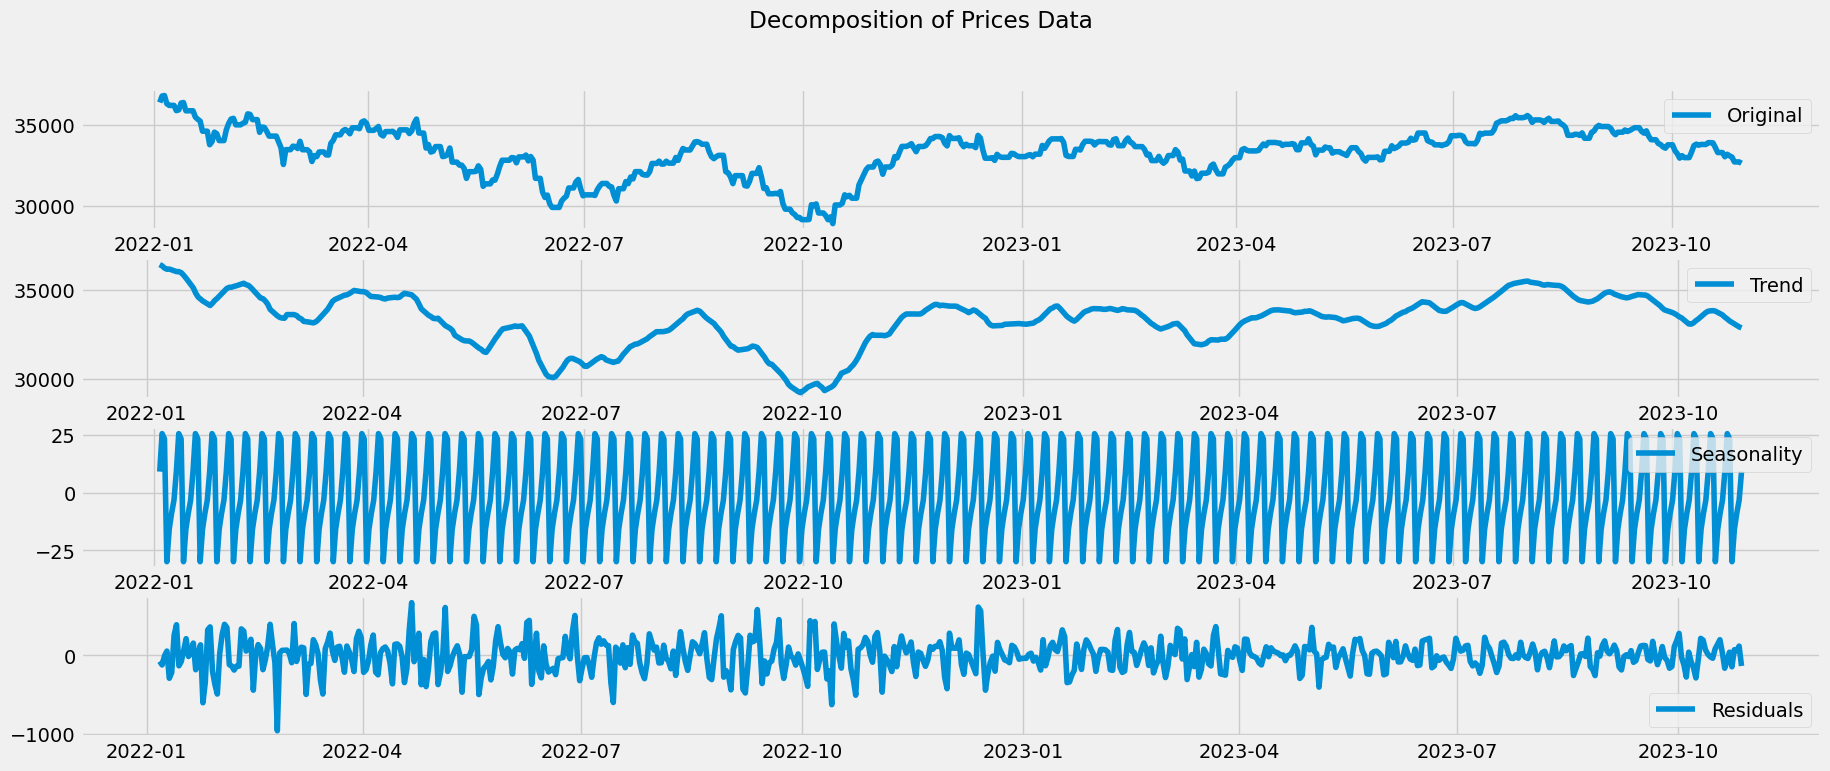

In [62]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime').asfreq('D')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

decomposition = sm.tsa.seasonal_decompose(data['Weighted_Price'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [63]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Weighted_Price)[1])

Dickey–Fuller test: p=0.035969


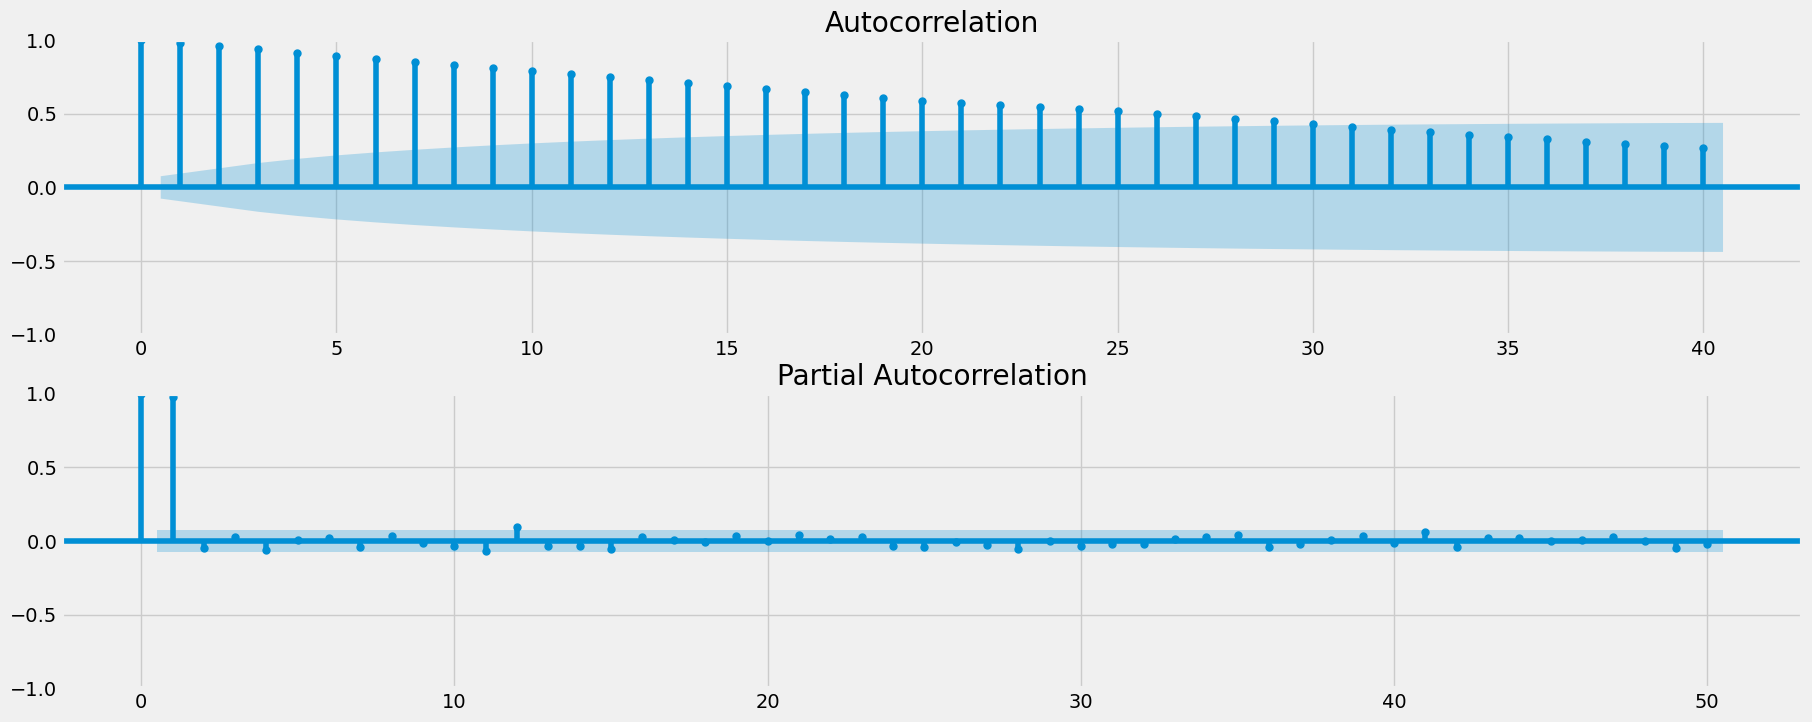

In [64]:

plt.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.Weighted_Price, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.Weighted_Price, ax=pyplot.gca(), lags=50)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.

In [65]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.Weighted_Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [66]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
41  (2, 0, 2, 1)  8808.779567
47  (2, 1, 2, 1)  8810.969215
23  (1, 0, 2, 1)  8820.309240
29  (1, 1, 2, 1)  8821.097017
35  (1, 2, 2, 1)  8823.320129
                                      SARIMAX Results                                       
Dep. Variable:                       Weighted_Price   No. Observations:                  666
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -4398.390
Date:                              Thu, 09 Nov 2023   AIC                           8808.780
Time:                                      11:42:31   BIC                           8835.425
Sample:                                  01-03-2022   HQIC                          8819.132
                                       - 10-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Dickey–Fuller test:: p=0.000000


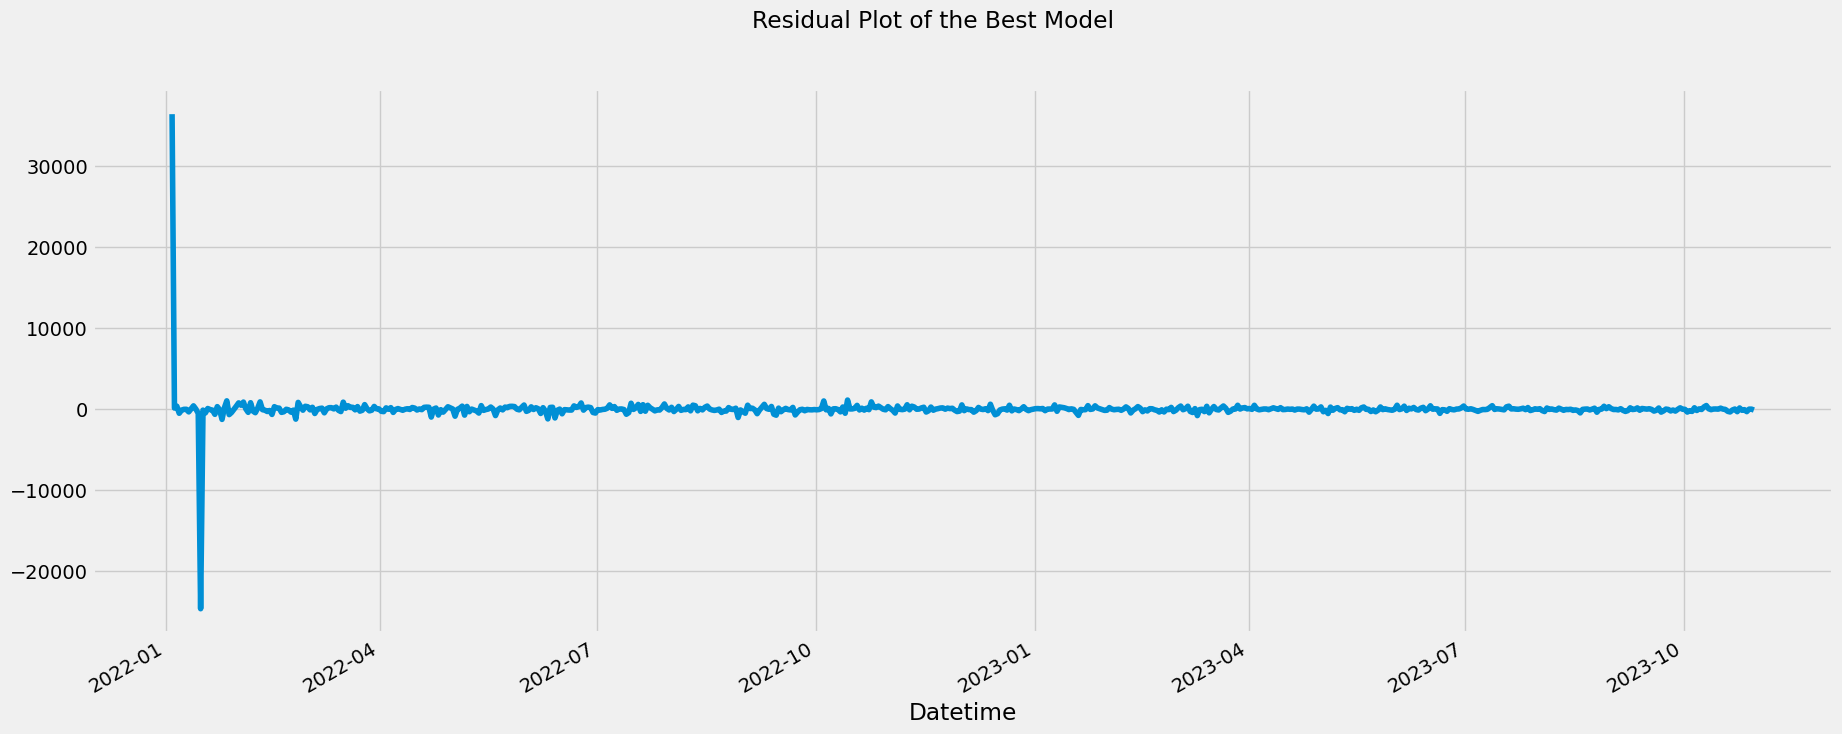

In [67]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

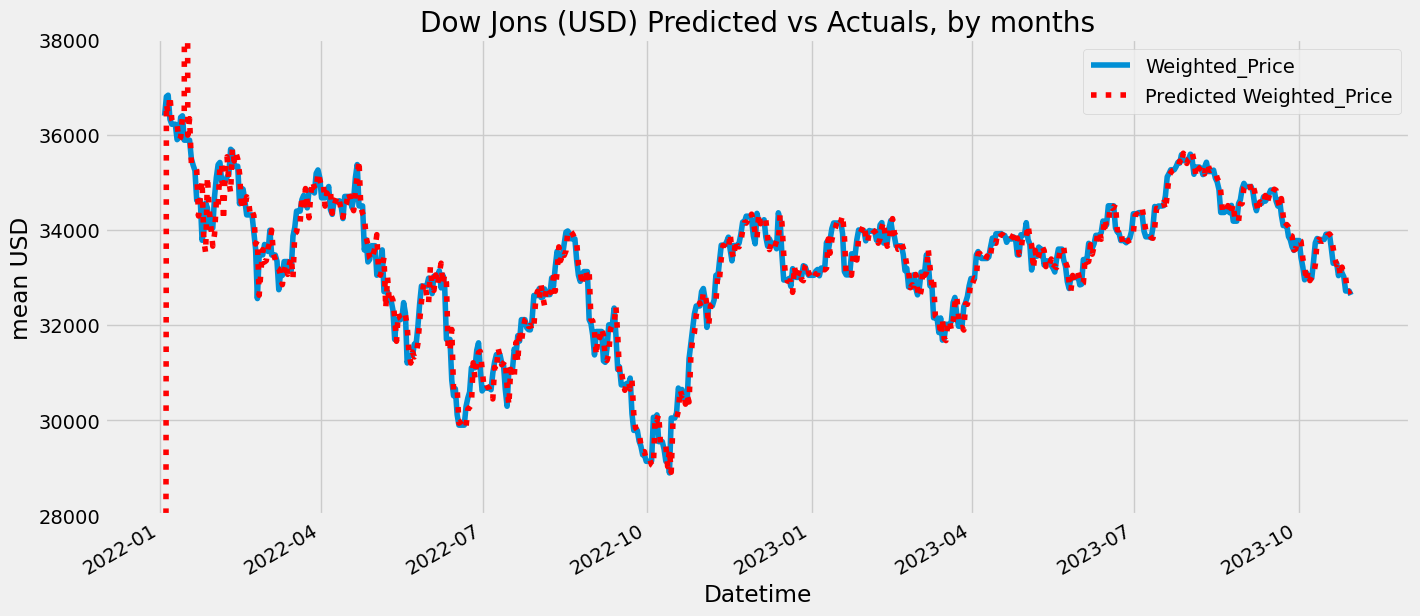

In [78]:
df_month2 = data[['Weighted_Price']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict()
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls=':', label='Predicted Weighted_Price')
plt.legend()
plt.title('Dow Jons (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.ylim(28000, 38000)
plt.show()

In [109]:
data = stockDf

In [110]:
data.head()

Datetime          Open          High           Low  \
0 2022-01-03 09:30:00-05:00  36321.589844  36502.511719  36246.449219   
1 2022-01-03 10:30:00-05:00  36464.800781  36468.328125  36324.199219   
2 2022-01-03 11:30:00-05:00  36367.878906  36420.039062  36280.351562   
3 2022-01-03 12:30:00-05:00  36417.339844  36441.121094  36367.410156   
4 2022-01-03 13:30:00-05:00  36441.050781  36524.000000  36419.539062   

          Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  36462.058594         0        0.0           0.0    36398.933594  
1  36368.128906  42963180        0.0           0.0    36398.717187  
2  36417.359375  30389408        0.0           0.0    36380.597656  
3  36441.121094  26296165        0.0           0.0    36421.622656  
4  36504.601562  30818008        0.0           0.0    36478.758594

In [111]:
# df_bitcoin = pd.DataFrame(data['bitcoin'])

df_bitcoin = data[['Datetime','Weighted_Price']]
df_bitcoin.set_index('Datetime', inplace = True)

                               SARIMAX Results                                
Dep. Variable:         Weighted_Price   No. Observations:                 3205
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -19268.603
Date:                Wed, 08 Nov 2023   AIC                          38549.206
Time:                        22:50:26   BIC                          38585.638
Sample:                             0   HQIC                         38562.267
                               - 3205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3252      0.015     22.198      0.000       0.296       0.354
ar.L2         -0.1305      0.017     -7.515      0.000      -0.164      -0.096
ar.L3          0.0224      0.020      1.114      0.2

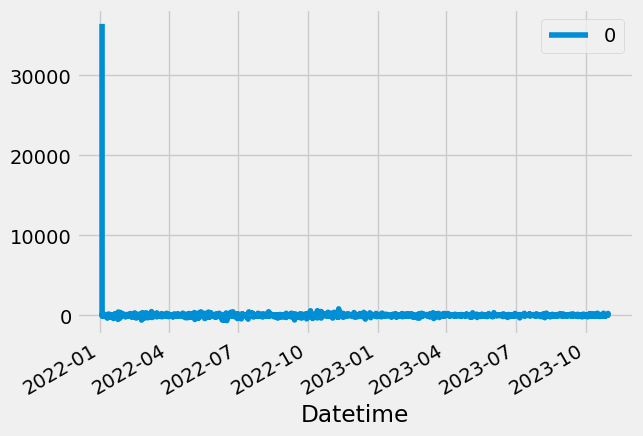

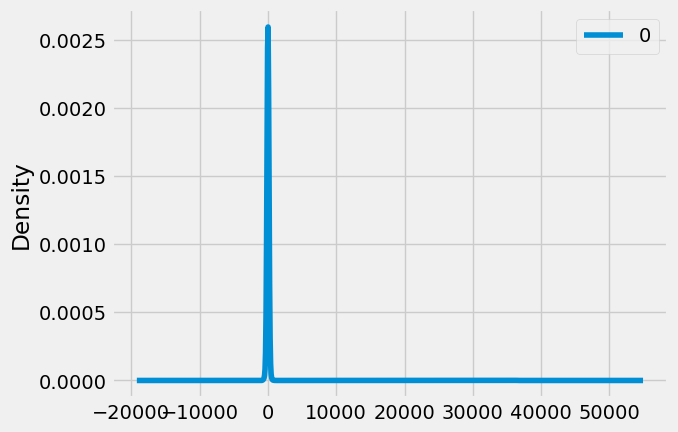

                  0
count   3205.000000
mean      10.494200
std      650.535944
min     -666.748987
25%      -43.671445
50%        1.300632
75%       43.778182
max    36398.933594


In [114]:
# fit model
model = ARIMA(df_bitcoin, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 4152.705


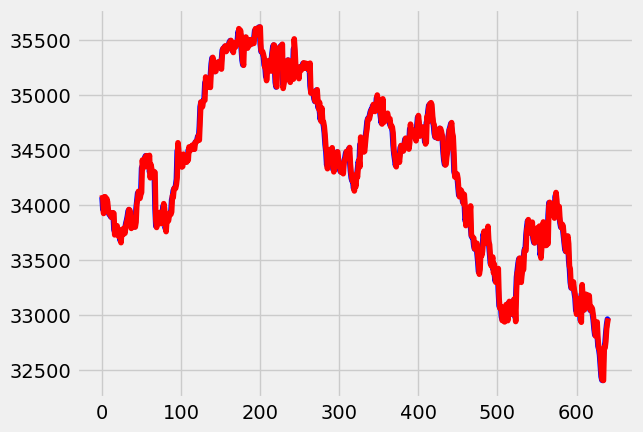

In [118]:
X = df_bitcoin.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot


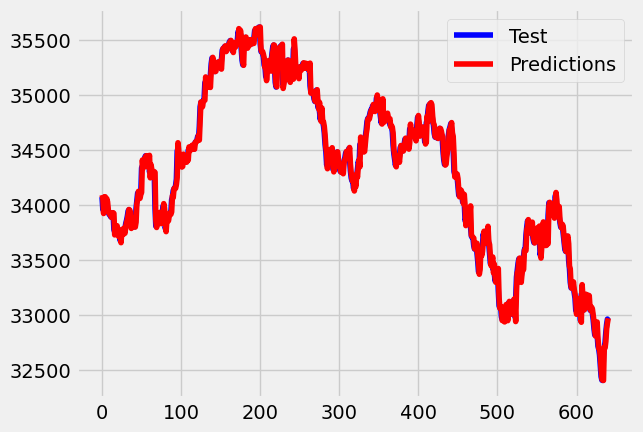

In [122]:
plt.plot(test, color = 'blue', label='Test')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()
plt.show()

In [185]:
############################################

In [213]:
data = stockDf
data.fillna(0, inplace=True)

In [214]:
# Unix-time to 
data.Timestamp = pd.to_datetime(data['Datetime'], unit='s')

# Resampling to daily frequency
data.index = data.Timestamp
data_d = data.resample('D').mean()

# Resampling to monthly frequency
data_month = data.resample('M').mean()

# Resampling to annual frequency
data_year = data.resample('A-DEC').mean()

# Resampling to quarterly frequency
data_Q = data.resample('Q-DEC').mean()

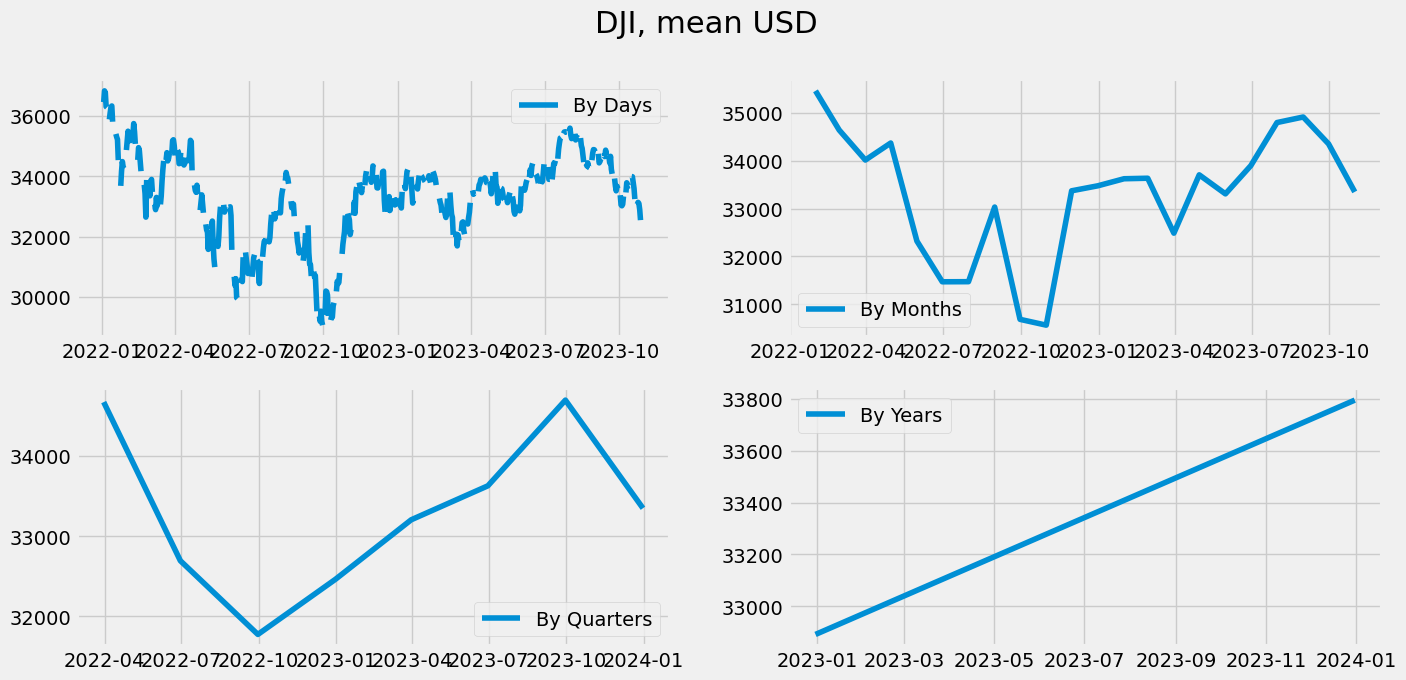

In [215]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('DJI, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(data_d['Weighted_Price'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(data_month['Weighted_Price'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(data_Q['Weighted_Price'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(data_year['Weighted_Price'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.629447


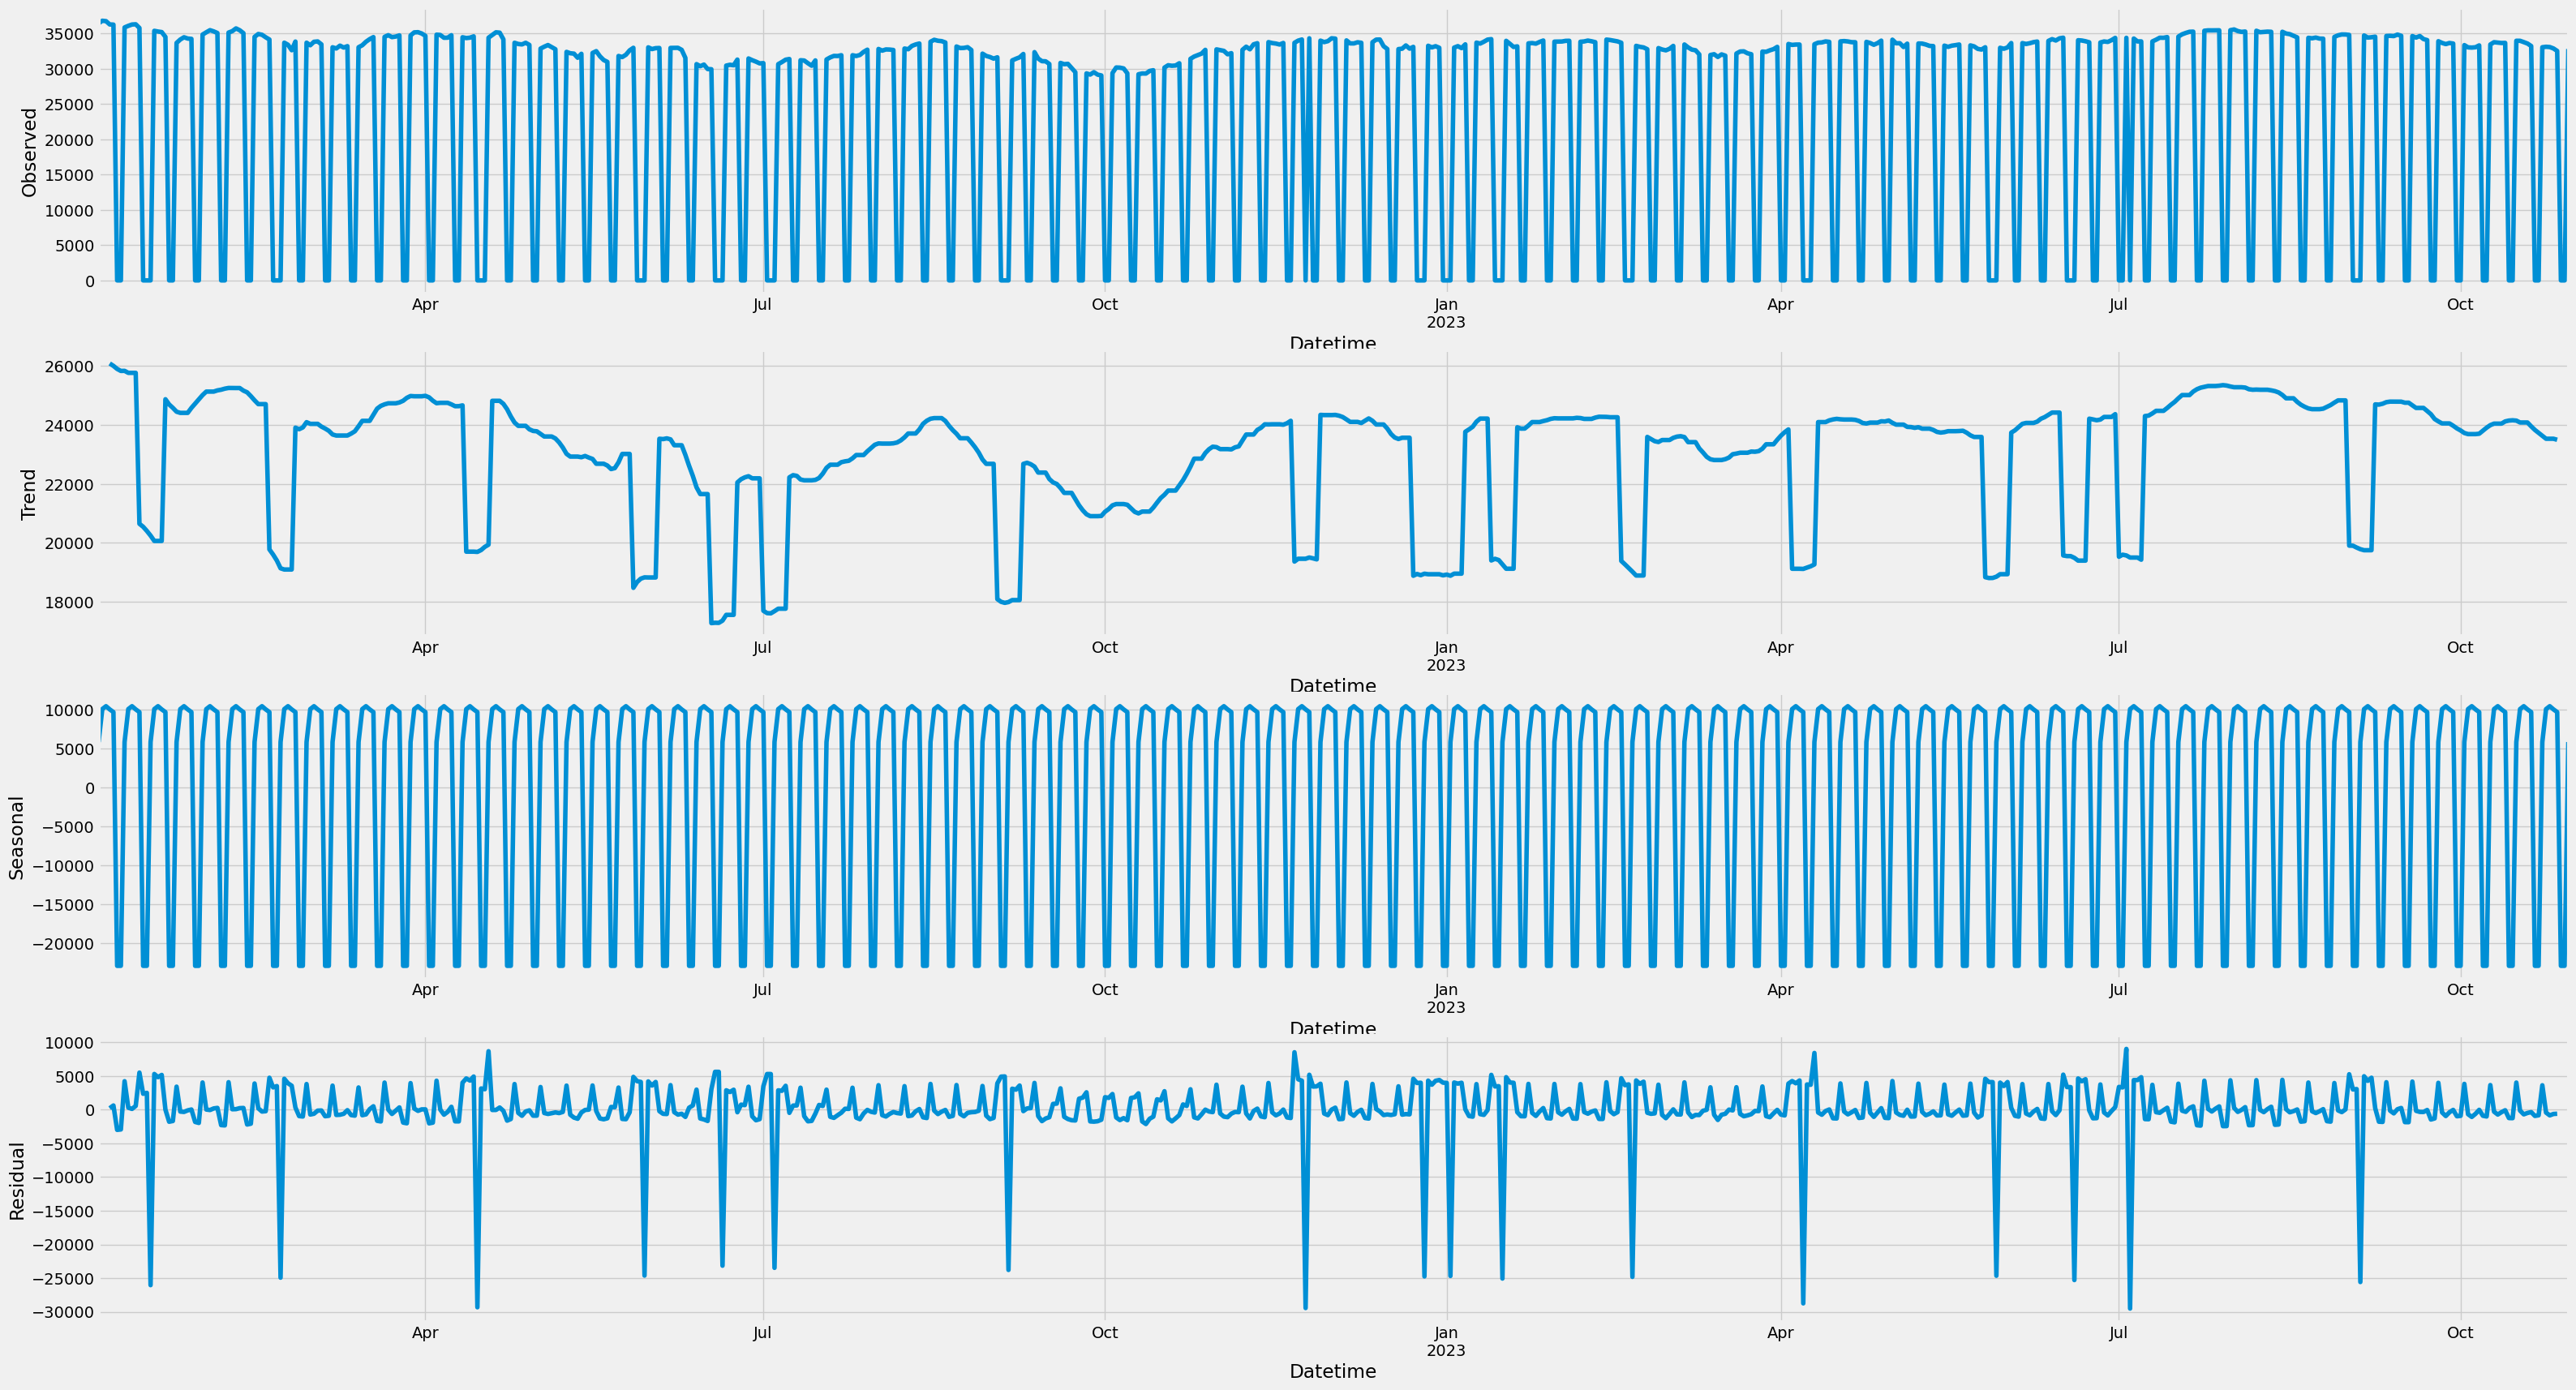

In [239]:
#Check how to plot data_month
result = sm.tsa.seasonal_decompose(data_d['Weighted_Price'], model='additive') 

# Plotting the decomposition components with adjusted size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(35, 20))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month['Weighted_Price'])[1])
# Display the plot
plt.show()

In [243]:
# Box-Cox Transformations
data_month['Weighted_Price_box'], lmbda = stats.boxcox(data_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.629447


In [244]:
# Seasonal differentiation
data_month['prices_box_diff'] = data_month.Weighted_Price_box - data_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.801350


In [247]:
# # Regular differentiation
# data_month['prices_box_diff2'] = data_month.prices_box_diff - data_month.prices_box_diff.shift(1)
# plt.figure(figsize=(15,7))

# # STL-decomposition
# sm.tsa.seasonal_decompose(data_month.prices_box_diff2[13:]).plot()   
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.prices_box_diff2[13:])[1])

# plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 9 observation(s)

<Figure size 1500x700 with 0 Axes>

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()